In [104]:
import os
import hardposit as hp
import fixed2float as fi
from pathlib import Path
import re
import ast
import math

In [105]:
import fixed2float
fixed2float.__version__

'4.0.1'

In [156]:
N, ES = 18, 1

In [157]:
ε = 10#1e-4

In [158]:
with open(Path("../tb_core_op_fma.log"), 'r') as f:
  log = f.read()
print(log)

(31, 70)
0x03524
(0x13524, 0x05e81) 0x0000000010f15f9200, 0x000083c5
(0x15e81, 0x0d609) 0x000000008ffc01b600, 0x000147fe
(0x0d609, 0x05663) 0x00000000948dcc94c0, 0x00014a47
(0x05663, 0x07b0d) 0x00000000961f3f15a0, 0x00014b10
(0x17b0d, 0x0998d) 0x00000000ec35d567a0, 0x0001761b
(0x3998d, 0x08465) 0x00000000e9a4678fe0, 0x000174d2
(0x28465, 0x05212) 0x00000000d17770a9e0, 0x000168bc
(0x35212, 0x0e301) 0x00000000bc35b4b2e0, 0x00015e1b
(0x3e301, 0x0cd0d) 0x00000000bbb8893480, 0x00015ddc
(0x3cd0d, 0x0f176) 0x00000000b99f097400, 0x00015cd0
(0x3f176, 0x0cd3d) 0x00000000b97f7865e0, 0x00015cc0
(0x1cd3d, 0x057ed) 0x0000000185e50785e0, 0x000190bd
(0x057ed, 0x0f78c) 0x000000018c6c77ace0, 0x0001918e
(0x1f78c, 0x0e9f9) 0x000000c97d3777ace0, 0x0001f64c
(0x1e9f9, 0x024c6) 0x000000ca4c620dace0, 0x0001f652
(0x324c6, 0x084c5) 0x000000ca40213fdbe0, 0x0001f652
(0x384c5, 0x0d2aa) 0x000000ca36912244e0, 0x0001f652
(0x3d2aa, 0x0f7e5) 0x000000ca34d97b4720, 0x0001f652
(0x3f7e5, 0x07277) 0x000000ca34d63e8cec, 0x0001

In [159]:
logs = log.splitlines()
# print(logs)

In [160]:
logs[0]

'(31, 70)'

In [161]:
# Fixed point params : Fx<M, B> := 1 sign bit, M int bits, B total bits    (B-M-1 fractional bits)
M, B = ast.literal_eval(logs[0])
M, B

(31, 70)

In [162]:
pattern = r"0x[0-9a-z]+"

diff_fma = [0] * len(logs)
diff_normal_mul = [0] * len(logs)

acc = 0
for (i, item) in enumerate(logs[1:]):
  results = re.findall(pattern, item)
  if len(results) == 1:
    p3 = hp.from_bits(int(results[0], 16), N, ES)
    po_std_mul = p3
    acc += p3.eval()
  else:
    p1 = hp.from_bits(int(results[0], 16), N, ES)
    p2 = hp.from_bits(int(results[1], 16), N, ES)
    print(f"i = {i}")
    print(f"{p1.eval()} * {p2.eval()} = {(p1*p2).eval()}")

    fixed = fi.from_bits(int(results[2], 16), M, B)
    print(f"fixed={fixed}")
    
    po_fma = hp.from_bits(int(results[3], 16), N, ES)
    po_std_mul += p1 * p2 
    print(f"po_fma     = {po_fma}")
    print(f"po_std_mul = {po_std_mul}")
    
    acc += p1.eval() * p2.eval()
    print(f"acc={acc}\n")
    
    diff_normal_mul[i] = 100*abs((po_std_mul.eval() - acc) / acc)
    diff_fma[i] = 100*abs((po_fma.eval() - acc) / acc)
    
    #assert acc == fixed.eval(), f"iter = {i} => acc = {acc}, fixed = {fixed.eval()}"
    assert math.isclose(acc, fixed.eval(), rel_tol=ε), f"iter = {i} => acc = {acc}, fixed = {fixed.eval()}"

i = 1
1.830322265625 * 0.12207794189453125 = 0.2234344482421875
fixed=0000000000000000000000000000000001000011110001010111111001001000000000 Fx<31,70>(72769049088) 0.26473225839436054
po_fma     = 001000001111000101 P<18,1>(33733) 0.2647247314453125
po_std_mul = 001000001111000101 P<18,1>(33733) 0.2647247314453125
acc=0.26473225839436054

i = 2
2.9532470703125 * 0.672149658203125 = 1.98504638671875
fixed=0000000000000000000000000000001000111111111100000000011011011000000000 Fx<31,70>(618408293888) 2.2497562672942877
po_fma     = 010100011111111110 P<18,1>(83966) 2.249755859375
po_std_mul = 010100011111111110 P<18,1>(83966) 2.249755859375
acc=2.2497562672942877

i = 3
0.672149658203125 * 0.10622406005859375 = 0.0713958740234375
fixed=0000000000000000000000000000001001010010001101110011001001010011000000 Fx<31,70>(638034154688) 2.3211547329556197
po_fma     = 010100101001000111 P<18,1>(84551) 2.3211669921875
po_std_mul = 010100101001000111 P<18,1>(84551) 2.3211669921875
acc=2.32115473295

In [163]:
hp.from_double(acc, N, ES)

011111111110010010 P<18,1>(130962) 409600.0

## Plotting displacement from 0, FMA vs std posit mul

In [164]:
import matplotlib.pyplot as plt

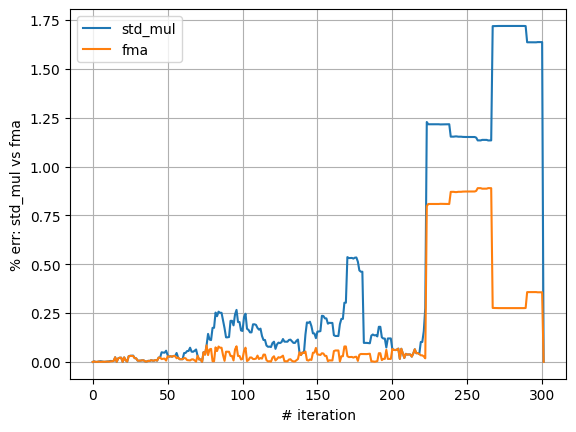

In [165]:
plt.xlabel("# iteration")
plt.ylabel("% err: std_mul vs fma")
plt.plot(diff_normal_mul, label="std_mul")
plt.plot(diff_fma, label="fma")
plt.legend()
plt.grid(True)
#plt.yscale('log')